# Instalación

**Los datos necesarios para realizar la práctica están en una carpeta compartida que se llama `data`, situada en "Shared with me". Para que el cuaderno pueda acceder a ella es necesario crear un link en "My Drive". El link se crea simplemente seleccionando "data", y desde el menu del botón derecho seleccione "Add a shortcut to Drive".**

**Una vez hecho esto, ejecute la siguiente celda. Esta celda montará el directorio de trabajo del cuaderno y verá la carpeta `data` a través del link. Para montar el directorio le pedirá que se registre en "Drive"**.

In [1]:
## Instalación: esta celda monta el directorio de trabajo
if 'google.colab' in str(get_ipython()):
    # Setup colab
    from google.colab import drive
    drive.mount('/drive')
    %cd /drive/My Drive/data
else:
    pass

# Redes convolucionales II

En este tutorial analizaremos en detalle la base convolucional de las **CNN**. El trabajo de la **base convolucional** consiste en extraer características visuales de la imagen, que posteriormente serán usadas por la cabeza de la red, por ejemplo, para clasificar imágenes. En esta ocasión analizamos los tipos de capas más importantes en el proceso de **extracción de características**: la **capa convolucional** con función de activación **ReLU** y la capa **Maximum Pooling**, que es una capa que sirve para concentrar y destacar las características más importantes del mapa de características. 

Para visualizar mejor los resultados del proceso de extracción de características, consideramos cada una de las operaciones fuera del contexto de la red neuronal. Para ello utilizamos funciones equivalentes a las que implementa la red pero sin configurar una estructura de capas. En primer lugar importamos las librerías necesarias:

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16
import numpy as np
import pandas as pd
from data_m3.utils.visiontools import show_kernel, circle, show_extraction, random_map
import warnings
warnings.filterwarnings("ignore") # to clean up output cells
from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# Set Matplotlib defaults
plt.rc('figure', autolayout=True)
plt.rc('axes', labelweight='bold', labelsize='large',
       titleweight='bold', titlesize=16, titlepad=10)
plt.rc('image', cmap='magma')

## Extracción de características

En esta sección analizamos los bloques básicos de la base convolucional: las capas de **convolución**, la función de activación **ReLU** y el **Max-pooling**, junto con su papel en el proceso de extracción de características. La extracción de características realizada por la base consiste en tres operaciones básicas:

1. **Filtrar** una imagen para obtener ciertas características a través de la operación **convolución**.
2. **Detectar** las características de interés dentro de la imagen filtrada a través de la función de activación, típicamente **ReLU**.
3. **Concentrar** la imagen para realzar las características, típicamente mediante **Max-pooling**.

La siguiente figura ilustra este proceso: se puede ver cómo éstas tres operaciones son capaces de aislar una característica particular de la imagen original, en este caso las líneas horizontales.

<figure><center>
<img src="https://i.imgur.com/IYO9lqp.png" width="600">
<figcaption style="textalign: center; font-style: italic">Etapas en la extracción de características: filtrado, detección y concentración.</center></figcaption>
</figure>

Típicamente la red puede realizar varias extracciones de características en paralelo sobre la misma imagen. En las redes de **convolución** modernas la capa final de la base convolucional puede generar del orden de 1000 características visuales diferentes.

### Capa convolucional

Las capas convolucionales realizan el proceso de filtrado, en *Keras* una capa convolucional se define del siguiente modo:

In [3]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    # More layers follow
])

A continuación analizamos los parámetros de la capa `Conv2D`: 
- `kernel_size`: son las dimensiones de la matriz denominada **kernel**, o filtro de **convolución**.  
- `filters`: es el número **kernels** o filtros que se aplican en una capa, donde cada **kernel** genera un mapa de características diferente.

Los **pesos** que una red neuronal convolucional aprende durante el entrenamiento son los elementos del **kernel**. Un ejemplo de **Kernel** de $3\times 3$ con 9 elementos se pueden ver en la siguiente figura:

<figure>
<center><img src="https://i.imgur.com/uJfD9r9.png" width="150">
<figcaption style="textalign: center; font-style: italic">Un kernel de convolución de 3x3.</center></figcaption>
</figure>

Puede pensarse que un **kernel** funciona escaneando una imagen, multiplicando la imagen por los elementos del **kernel** y generando una *suma ponderada* entre los valores de la entrada y los del **kernel**. El valor de la **convolución** es alto cuando existe similitud entre la imagen y el **kernel**, y es bajo cuando no existe relación alguna. De este modo, el **kernel** actuará como una especie de lente polarizada, transmitiendo o atenuando ciertos patrones de información presentes en la entrada.  

<figure><center>
<img src="https://i.imgur.com/j3lk26U.png" width="250">
<figcaption style="textalign: center; font-style: italic">Un kernel actúa como una lente que escanea la imagen.</center></figcaption>
</figure>

Los **kernels** definen las conexiones entre las entradas y las salidas de la capa, por ejemplo, el **kernel** de la figura anterior, de dimensiones $3\times 3$, conectará nueve neuronas de entrada con cada neurona de salida. Al establecer las dimensiones del **kernel** con el parámetro `kernel_size`, se configuran automáticamente las conexiones entre la capa de entrada y salida. Típicamente, el **kernel** tendrá dimensiones impares --valores típicos son `kernel_size=(3, 3)` o `(5, 5)`--. El resultado de la **convolución** con un **kernel** genera un mapa de características, por tanto la estructura de cada **kernel** determina el tipo de características del mapa de salida. Durante el entrenamiento, una red convolucional intenta aprender qué características necesita (o son las más adecuadas) para resolver el problema en cuestión, lo cual implica encontrar los mejores valores para los elementos de los **kernels**. En la siguiente figura se muestran algunos **kernels** y los **mapas de características** que producen.

<figure><center>
<img src="https://i.imgur.com/JxBwchH.png" width="800"><figcaption style="textalign: center; font-style: italic">Kernels y los mapas de características que generan.</center></figcaption>
</figure>

Como se ha comentado, según la estructura del **kernel** se puede deducir el tipo de características que genera, por ejemplo, en la figura anterior el **kernel** de la izquierda y el central filtrarán las estructuras horizontales en la imagen. Con el parámetro `filters` configuramos el número de **kernels** que actúan en paralelo, por tanto, es igual al número de mapas de características que obtenemos a la salida.

### Detección con ReLU

Después del filtrado, los mapas de características pasan por la función de activación. A continuación recordamos la forma de la función **rectificadora** (**ReLU**), que es la más utilizada en las capas convolucionales:

<figure><center>
<img src="https://i.imgur.com/DxGJuTH.png" width="400">
<figcaption style="textalign: center; font-style: italic">Función rectificadora, una función lineal con la parte negativa rectificada a 0.</center></figcaption></figure>

La activación **ReLU** puede ser definida en una capa propia, con la opción `activation`, aunque lo más frecuente es incluirla como función de activación dentro de la capa `Conv2D`, tal y como hicimos en el caso de las capas `dense`.

In [4]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3, activation='relu')
    # More layers follow
])

La función de activación realiza una correspondencia entre la entrada y la salida de acuerdo con alguna medida de importancia. La activación **ReLU** considera que los valores negativos no son importantes y los elimina (les asigna el valor 0). Sin embargo, los píxeles positivos los considera con la importancia del valor que tienen, por eso los mantiene sin modificar. A continuación se muestra la aplicación de **ReLU** a los mapas de características anteriores. Observe cómo consigue aislar las características eliminando todo lo negativo.

<figure><center>
<img src="https://i.imgur.com/dKtwzPY.png" width="800">
<figcaption style="textalign: center; font-style: italic">Aplicación de ReLU a los mapas de características.</center></figcaption>
</figure>

### Max pooling

Una vez realizada la extracción y detección de las características mediante el filtrado y la función de activación `ReLu`, abordamos un procedimiento para la concentración de características mediante la operación denominada **Maximum Pooling**. En una red neuronal, esta operación se realiza mediante la capa `MaxPool2D`, como se puede ver en la siguiente celda.

In [5]:
model = keras.Sequential([
    layers.Conv2D(filters=64, kernel_size=3), # activation is None
    layers.MaxPool2D(pool_size=2),
    # More layers follow
])

Una capa `MaxPool2D` es parecida a una capa `Conv2D`, pero en vez de calcular un promedio basado en el **kernel**, calcula el máximo dentro de una vecindad de tamaño `pool_size`. A diferencia de la capa convolucional, la capa `MaxPool2D` no tiene pesos entrenables. El proceso consiste en tomar una vecindad de píxeles en el mapa de características y sustituirlo por el valor máximo de la vecindad, como se puede ver en la siguiente figura. La cuadrícula representada en blanco en la figura de la izquierda delimita la vecindad de píxeles donde se aplica el **MaxPooling**.

<figure><center>
<img src="https://imgur.com/hK5U2cd.png" width="600" alt=""><figcaption style="textalign: center; font-style: italic">En la imagen de la izquierda se muestra el mapa de características, la cuadrícula mostrada en blando delimita la vecindad de píxeles donde se aplica el MaxPooling y el resultado se muestra en la imagen de la derecha. Cada vecindad ha sido sustituida por un único píxel con el valor máximo de toda la vecindad</center></figcaption></figure>

Después de aplicar la función de activación **ReLU**, el mapa de características termina con grandes áreas que contienen valores nulos. La propagación de valores nulos a través de la red aumenta el tamaño del modelo sin añadir información relevante. El proceso de **MaxPooling** permite *concentrar* el mapa de características para retener sólo la parte más relevante del mismo. Cuando se aplica después de la activación de **ReLU**, **MaxPool** tiene el efecto de "intensificar" el mapa de características, ya que elimina los valores que no son máximos en cada vecindad y aumenta la proporción de píxeles activos respecto de los que tienen valor nulo.

#### Invarianza de traslación
Hemos mencionado que las características con valor nulo no tienen interés práctico al transmitirse por la red. Sin embargo, esto no significa que no tengan ninguna información. De hecho, los píxeles nulos llevan *información de la posición*: permiten posicionar las características dentro de la imagen. Cuando `MaxPool2D` elimina algunos de estos píxeles, elimina parte de la información sobre la posición de las características dentro del mapa. Esto confiere a la red de una propiedad llamada **invarianza de traslación**, que permite la detección de las características independientemente de su *ubicación* en la imagen. Observe lo que ocurre cuando aplicamos repetidamente el proceso de **MaxPooling** al siguiente mapa de características. Los dos puntos de la imagen original se vuelven indistinguibles tras la repetición de **MaxPooling**, por lo que se ha perdido parte de la información de la posición. Como la red ya no puede distinguir los puntos en el mapa de características, tampoco puede distinguirlos en la imagen original.

<figure>
<center><img src="https://i.imgur.com/97j8WA1.png" width="800" alt=""></center>
<figcaption style="textalign: center; font-style: italic"><center>El MaxPooling pierde parte de la información de la posición.</center></figcaption>
</figure>

En la figura anterior se observa la **invarianza de traslación**, que se obtiene cuando las características están separadas por una distancia reducida. Sin embargo, cuando las características están muy separadas seguirán siendo diferentes después del **MaxPooling**, ya que se ha perdido *parte* de la información de la posición, pero no toda. Por eso decimos que existe invarianza frente a desplazamientos reducidos. Un ejemplo se puede ver en la siguiente figura:

<figure>
<center><img src="https://i.imgur.com/kUMWdcP.png" width="800"></center>
<figcaption style="textalign: center; font-style: italic"><center>Las características que estaban muy separadas aún se mantienen distinguibles.</center></figcaption>
</figure>

Esta invarianza tan curiosa es una propiedad interesante para un clasificador de imágenes, ya que los pequeños desplazamientos se producen cuando cambia la perspectiva o el encuadre en la imagen. De este modo, si se produce un pequeño cambio en la posición de la característica, el clasificador lo sigue reconociendo como la misma característica. Esta invarianza está *integrada* en la estructura de la red a través de las operaciones de **MaxPooling**, por lo que no se requieren datos para entrenar esta funcionalidad. Es decir, una red neuronal con **MaxPooling** no tiene que aprender a ignorar pequeños desplazamientos en las características, porque la propia red no los ve. Esta característica aporta una gran eficiencia a las redes convolucionales respecto de las redes con capas densas.

### Global Average Pooling

Aunque el **MaxPool** es el tipo de "agrupación" más utilizado en redes convolucionales, existe otro tipo que se utiliza en la parte final de la red, en la cabeza. Se denomina **global average pooling** y consiste en reemplazar cada mapa de características con su valor promedio. Se suele utilizar como una alternativa a las capas `Dense` en la cabeza de la red.

``` python
model = keras.Sequential([
    pretrained_base,
    layers.GlobalAvgPool2D(),
    layers.Dense(1, activation='sigmoid'),
])
```

En el código anterior no aparece la típica capa `Flatten`, que normalmente viene después de la base y cuyo cometido consiste en transformar las características bidimensionales en un vector unidimensional, que es lo que requiere el clasificador. En este caso, la capa `GlobalAvgPool2D` cumple esta función, ya que reemplaza cada mapa de características con su valor promedio. Aunque es muy destructivo, a menudo suele funcionar bien y tiene la ventaja de reducir el número de parámetros del modelo. En la siguiente celda se genera un mapa de características aleatorio y se realiza un **Average Pooling**. El resultado es un vector unidimensional que recoge el valor promedio de cada mapa de características. Ejecute la siguiente celda unas cuantas veces para tener una idea del funcionamiento.

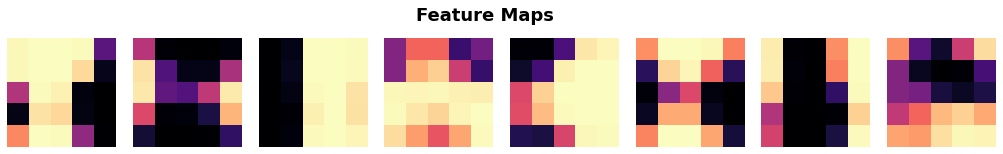

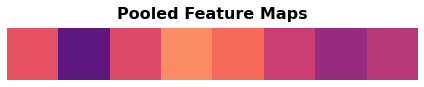

In [6]:
## Global Average Pooling
feature_maps = [random_map([5, 5], scale=0.1, decay_power=4) for _ in range(8)]

gs = gridspec.GridSpec(1, 8, wspace=0.01, hspace=0.01)
plt.figure(figsize=(18, 2))
for i, feature_map in enumerate(feature_maps):
    plt.subplot(gs[i])
    plt.imshow(feature_map, vmin=0, vmax=1)
    plt.axis('off')
plt.suptitle('Feature Maps', size=18, weight='bold', y=1.1)
plt.show()

# reformat for TensorFlow
feature_maps_tf = [tf.reshape(feature_map, [1, *feature_map.shape, 1])
                   for feature_map in feature_maps]

global_avg_pool = tf.keras.layers.GlobalAvgPool2D()
pooled_maps = [global_avg_pool(feature_map) for feature_map in feature_maps_tf]
img = np.array(pooled_maps)[:,:,0].T

plt.imshow(img, vmin=0, vmax=1)
plt.axis('off')
plt.title('Pooled Feature Maps')
plt.show();

El proceso de **average pooling** reduce el número de características, y con ello la información que le llega a la cabeza de la red. Hay que tener en cuenta que el proceso de **average pooling** destruye o camufla una buena parte de la información contenida en el mapa de características. En un proceso de clasificación esto no suele ser un problema porque solo nos interesa la presencia o no de ciertos detalles, pero si la tarea de la cabeza es más compleja hay que tener cuidado de no reducir demasiado la información del mapa de características que llega a la cabeza de la red.

## Ejemplo

Para visualizar el proceso de extracción de características vamos a realizar un ejemplo con una imagen arbitraria de entrada. Para ello vamos a definir manualmente la **convolución** y el proceso de **MaxPool**. En este caso no usaremos una red neuronal, en su lugar usaremos las mismas funciones que realiza internamente la red, pero sin la estructura de la red. En particular, realizaremos un filtrado con el **kernel** de **convolución**, seguido de la aplicación de la función de activación **ReLu** para la detección de características. Finalmente concentramos la información mediante **MaxPooling**. 

En primer lugar cargamos y mostramos la imagen inicial:

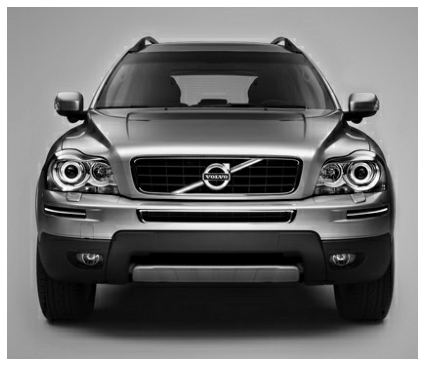

In [7]:
image_path = 'data_m3/figs/car_feature.jpg'
image = tf.io.read_file(image_path)
image = tf.io.decode_jpeg(image)
#print(image.shape)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image), cmap='gray')
plt.axis('off')
plt.show();

En el paso de filtrado definimos manualmente un **kernel** y realizamos la **convolución**. En este caso el **kernel** está especializado en la "detección de bordes" y en *Tensorflow* se define como un tensor mediante `tf.constant`, del mismo modo que se define un **array** en `Numpy` con `np.array`. En la siguiente celda definimos manualmente el **kernel** y lo visualizamos:

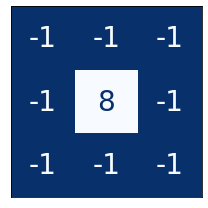

In [8]:
kernel = tf.constant([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1],
])

plt.figure(figsize=(3, 3))
show_kernel(kernel)


En la siguiente celda se realizan algunos cambios de formato necesarios para que la imagen y el **kernel** sean compatibles con el tipo de datos de `TensorFlow`. Ejecute la siguiente celda:

In [9]:
# Reformat for batch compatibility.
image = tf.image.convert_image_dtype(image, dtype=tf.float32)
image = tf.expand_dims(image, axis=0)
kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
kernel = tf.cast(kernel, dtype=tf.float32)

`TensorFlow` incluye muchas operaciones matemáticas realizadas internamente por las redes neuronales en el módulo [`tf.nn`](https://www.tensorflow.org/api_docs/python/tf/nn). Estas operaciones se pueden utilizar fuera del contexto de las redes neuronales, simplemente como funciones. En nuestro caso utilizaremos este tipo de funciones para realizar la **convolución** y la activación: `conv2d` y `relu`. En primer lugar realizamos la operación de filtrado usando el **kernel** definido previamente:

2022-11-12 19:08:07.740601: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8600
2022-11-12 19:08:08.174003: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


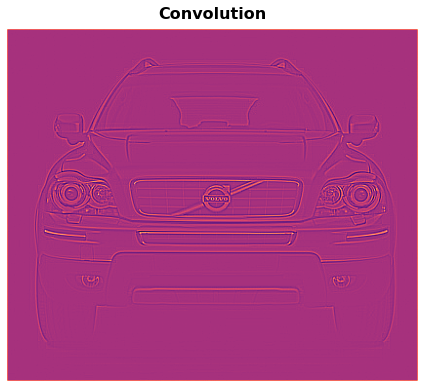

In [10]:
image_filter = tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME',
)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_filter))
plt.axis('off')
plt.title('Convolution')
plt.show();

Finalmente se realiza el paso de detección con la función **ReLu**, la cual no contiene ningún parámetro para configurar.

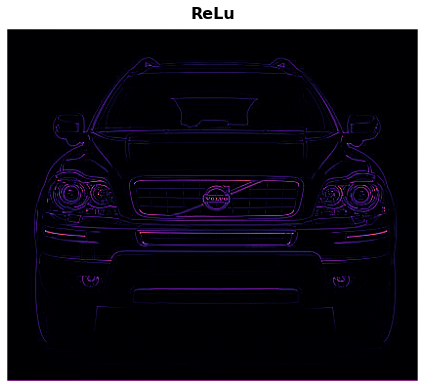

In [11]:
image_detect = tf.nn.relu(image_filter)

plt.figure(figsize=(6, 6))
plt.imshow(tf.squeeze(image_detect))
plt.axis('off')
plt.title('ReLu')
plt.show();

Al igual que hemos hecho antes, utilizamos una función incluida en `tf.nn` para aplicar el **MaxPooling**, denominada `tf.nn.pool`. 

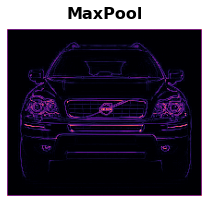

In [12]:
image_condense = tf.nn.pool(
    input=image_detect, # image in the Detect step above
    window_shape=(2, 2),
    pooling_type='MAX',
    # we'll see what these do in the next lesson!
    strides=(2, 2),
    padding='SAME',
)

plt.figure(figsize=(3, 3))
plt.imshow(tf.squeeze(image_condense))
plt.axis('off')
plt.title('MaxPool')
plt.show();

El paso de **MaxPool** ha intensificado las características concentrando la imagen alrededor de los píxeles más activos. Si representamos los tres resultados simultáneamente veremos que el proceso de **MaxPool** reduce el número de píxeles del mapa concentrando las características:

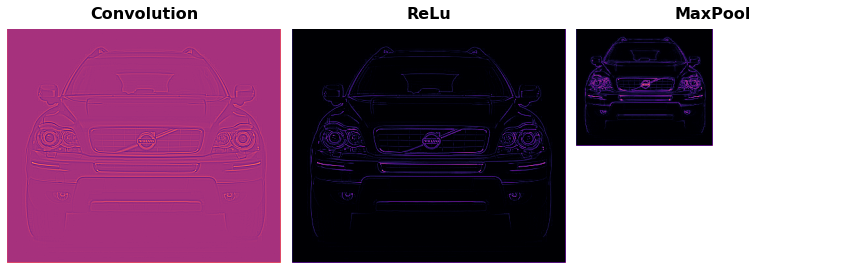

In [13]:
x,y = tf.squeeze(image_detect).shape
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(tf.squeeze(image_filter))
plt.axis([0, y, x, 0])
plt.axis('off')
plt.title('Convolution')

plt.subplot(1, 3, 2)
plt.imshow(tf.squeeze(image_detect))
plt.axis([0, y, x, 0])
plt.axis('off')
plt.title('ReLu')

plt.subplot(1, 3, 3)
plt.imshow(tf.squeeze(image_condense))
plt.axis([0, y, x, 0])
plt.axis('off')
plt.title('MaxPool')
plt.show();

Hemos creado "manualmente" el mapa de características de un solo **kernel**. En la práctica, los mapas de características son utilizados por la cabeza de la red para resolver el problema encomendado, en nuestro caso la clasificación. Podemos imaginar que ciertos rasgos pueden ser más característicos de *coches* y otros más característicos de *Camionetas*. Durante el entrenamiento, la red neuronal convolucional debe obtener los **kernels** cuyas características diferencian las dos clases.

## Ventana deslizante

Hasta ahora hemos implementado el proceso de extracción de características de una imagen:
1. *filtrado* con una capa de **convolución**
2. *detección* con activación **ReLU**
3. *concentración* con capas **MaxPooling**.

En esta sección analizamos las relaciones entre la **convolución** y el **MaxPooling**, ya que tienen una característica común: ambas se realizan sobre una **ventana deslizante**. En el caso de la **convolución**, la "ventana" viene dada por las dimensiones del **kernel**, `kernel_size`, mientras que en el caso del **MaxPooling**, se utiliza una ventana de dimensiones `pool_size`. En la figura se puede ver el deslizamiento de una ventana de $3\times 3$ a lo largo de una imagen.

<figure>
<center><img src="https://i.imgur.com/LueNK6b.gif" width=400 alt="">
<figcaption style="textalign: center; font-style: italic">Ventana deslizante bidimensional.</center></figcaption>
</figure>

Hay dos parámetros adicionales que afectan tanto a las capas de **convolución** como a las de **maxPooling**: el desplazamiento de la ventana en cada paso, denominado `strides`, y el rellenado de ceros en los bordes de la imagen, denominado `padding`. El parámetro `strides` determina el número de píxeles que se desplaza la ventana en cada paso, y el parámetro `padding` describe cómo gestionar los píxeles en los bordes de la entrada. Con estos dos parámetros, la definición de las dos capas es la siguiente:

In [14]:
model = keras.Sequential([
    layers.Conv2D(filters=64,
                  kernel_size=3,
                  strides=1,
                  padding='same',
                  activation='relu'),
    layers.MaxPool2D(pool_size=2,
                     strides=1,
                     padding='same')
    # More layers follow
])

### Strides

Como se ha comentado, es el número de píxeles que la ventana se desplaza en cada paso. Necesitamos especificar el desplazamiento horizontal y vertical a lo largo del mapa de características. La siguiente animación muestra `strides=(2, 2)`, es decir, un movimiento de 2 píxeles en cada dirección. Cuando el valor del `strides` es el mismo en ambas direcciones, sólo se requiere un solo valor; por ejemplo, en lugar de `strides=(2, 2)` podría utilizar `strides=2`.

<figure><center>
<img src="https://i.imgur.com/Tlptsvt.gif" width=400 alt="">
<figcaption style="textalign: center; font-style: italic">Ventana deslizante con paso de (2, 2).</center></figcaption>
</figure>

Cuando el **strides** es mayor que 1, la ventana deslizante prescinde de algunos píxeles de la entrada en cada paso. En el caso de la **convolución**, debido a que queremos extraer características de alta calidad, las capas convolucionales suelen tener `strides=(1, 1)`. Aumentar el paso significa que perdemos información potencialmente valiosa en nuestras características. Sin embargo, las capas de **maxPooling** casi siempre tendrán valores de `strides` mayores que 1, como `(2, 2)` o `(3, 3)`, pero no mayores que el tamaño de la propia ventana. De lo contrario, el **maxPooling** se saltará las características que no estén dentro del área que cubre la ventana deslizante. 

### Padding

Cuando se aplica una ventana deslizante se plantea el problema de cómo gestionar los píxeles del perímetro de la entrada. Si el **kernel** se desliza dentro de la imagen, nunca estará centrado sobre los píxeles del perímetro, como se puede ver en la siguiente figura:

<figure>
<center><img src="https://i.imgur.com/LueNK6b.gif" width=300 alt="">
<figcaption style="textalign: center; font-style: italic">Ventana deslizante bidimensional.</center></figcaption>
</figure>

Según apliquemos una ventana deslizante, tanto para la **convolución** como para el **maxpooling**, el mapa de características a la salida reduce su tamaño, perdiendo los píxeles del perímetro. El comportamiento de la **convolución** en el perímetro está determinado por el parámetro `padding`. En **TensorFlow** existen dos opciones: o bien `padding=same` o bien `padding=valid`. Cada una de ellas tiene sus ventajas y desventajas. Cuando establecemos `padding=valid`, la ventana de **convolución** permanecerá completamente dentro de la entrada, como en el caso descrito anteriormente. En este caso, la reducción en el tamaño de la salida, que depende del tamaño del **kernel**, puede limitar el número de capas que puede contener la red, especialmente cuando las entradas son de tamaño reducido. La alternativa consiste en utilizar la opción de `padding=same`. Este método **expande** la entrada con ceros alrededor de los bordes, usando los ceros necesarios para que el tamaño de la salida sea el mismo que el de la entrada, como se puede ver en la siguiente figura:

<figure><center>
<img src="https://i.imgur.com/RvGM2xb.gif" width=400 alt="">
<figcaption style="textalign: center; font-style: italic">Ventana deslizante con *padding* *same*.</center></figcaption>
</figure>

Dado que no estamos tratando todos los píxeles exactamente igual, podríamos tener un *efecto de borde*, ya que la introducción de ceros puede tener el efecto de diluir la influencia de los píxeles en los bordes en la entrada, para dar lugar a los píxeles en los bordes de la salida. La mayoría de las redes convolucionales modernas utilizan alguna combinación de ambos tipos de `padding`, además esta combinación puede ser un parámetro entrenable. El modelo **VGG16** que hemos visto anteriormente usa el `padding` tipo `same` en todas sus capas convolucionales. La arquitectura de la red **VGG16**  utiliza la **convolución** con pasos de 1 y el **maxPooling** con ventanas de $2\times 2$ y `strides` de 2. 

### Ejemplo - ventana deslizante

Para entender el efecto de los parámetros de la ventana deslizante, vamos a observar la extracción de características en una imagen de baja resolución, en la que se pueden ver los píxeles individuales. La imagen consiste en un círculo y el kernel es un detector de bordes horizontales, el código siguiente crea la imagen y el **kernel**.

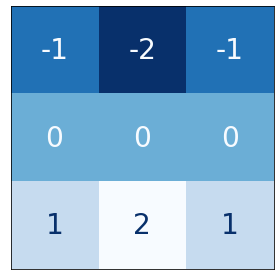

In [15]:
image = circle([64, 64], val=1.0, r_shrink=3)
image = tf.reshape(image, [*image.shape, 1])
# Bottom sobel
kernel = tf.constant(
    [[-1, -2, -1],
     [0, 0, 0],
     [1, 2, 1]],
)

show_kernel(kernel)

En la siguiente figura se muestra la **convolución** con pasos de 1 y el **maxPooling** con ventanas de $2\times 2$ y `stride` de 2. 

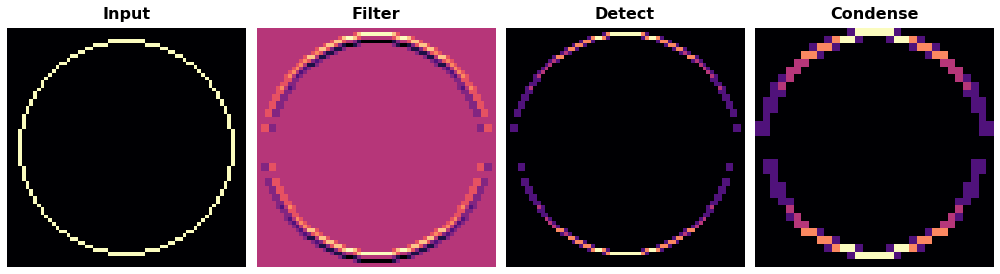

In [16]:
show_extraction(
    image, kernel,
    # Window parameters
    conv_stride=1,
    pool_size=2,
    pool_stride=2,
    subplot_shape=(1, 4),
    figsize=(14, 6),
)

El **kernel** fue diseñado para detectar líneas horizontales, y podemos ver que en el mapa de características resultante las partes más horizontales de la entrada terminan con la mayor activación. A continuación analizamos la situación cuando cambiamos el `stride` de la **convolución** a 3.

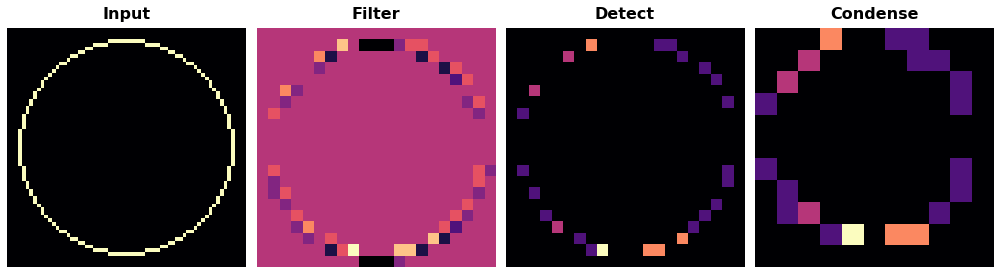

In [17]:
show_extraction(
    image, kernel,
    # Window parameters
    conv_stride=3,
    pool_size=2,
    pool_stride=2,
    subplot_shape=(1, 4),
    figsize=(14, 6),    
)

Las características que pretendíamos extraer, los bordes horizontales, no se visualizan claramente y la calidad de las características se ha reducido notablemente. El círculo de la entrada tiene una resolución de un sólo píxel de ancho. Una **convolución** con pasos de 3 píxeles hace que se pierda la resolución inicial e impide la producción de un buen mapa de características. En ocasiones se puede utilizar una **convolución** con un paso mayor que 1 pixel en su capa inicial, lo cual suele ir acompañado de un **kernel** más grande. Por ejemplo, el modelo `ResNet50` utiliza **kernels** de $7\times 7$ con pasos de 2 píxeles en su primera capa. Esto parece acelerar la producción de características a gran escala sin sacrificar demasiada información de la entrada.

## Campo receptivo

Puede resultar interesante rastrear las conexiones desde una neurona hacia atrás, hasta llegar a la imagen de entrada. Los píxeles de la entrada a los que está conectada una neurona forman el **campo receptivo** de la neurona. Es decir, una neurona solo recoge información de un conjunto de píxeles de la imagen, su campo receptivo. Como hemos visto, si la capa superior de una red proviene de una **convolución** con un **kernel** de $3 \times 3$, entonces cada neurona de esa capa recibe información de una zona de $3 \times 3$ píxeles, sin contar los píxeles del borde, en el caso de que haya  `padding=same`. Si se añade otra capa convolucional intermedia con un **kernel** de $3 \times 3$, el resultado es el de la siguiente figura:

<figure><center>
<img src="https://i.imgur.com/HmwQm2S.png" alt="" width=250>
<figcaption style="textalign: center; font-style: italic">Campo receptivo de dos capas de convolución.
</center></figcaption>
</figure>

Si seguimos las conexiones desde la neurona situada en la parte superior hasta la capa de la base, se puede ver que está conectada a un área de $5 \times 5$ píxeles en la entrada. Es decir, cada neurona en la parte superior tiene un campo receptivo de $5 \times 5$. 

Obsérvese que en un caso hipotético de tres **kernels** de $3 \times 3$, tendríamos un campo receptivo de $7 \times 7$, y los tres kernels contienen 27 parámetros en total. Un solo **kernel** con el mismo campo receptivo debería tener un tamaño de $7 \times 7$, el cual tiene 49 parámetros. Como se puede ver, la estrategia de convoluciones apiladas permite obtener grandes campos receptivos con un numero de parámetros relativamente reducido. 

# Conclusiones 

Hemos aprendido los componentes que forman la base convolucional de una **CNN**, realizando manualmente el proceso de extracción de características. Hemos analizado el proceso de **filtrado** con capas `Conv2D`, **detección** con la función de activación `relu` y la **concentración** con `MaxPool2D`. Además, hemos visto una operación común en la **convolución** y el **MaxPooling**: la **ventana deslizante** y los parámetros que la regulan. Finalmente, hemos definido el **campo receptivo** de una neurona en una red convolucional, poniendo de manifiesto la estructura local de la transformación. Esta es una diferencia clave respecto de las capas **densas**. Como seguramente ya haya advertido, una de las grandes ventajas de las redes neuronales sobre los modelos tradicionales es que dada una estructura adecuada de red, ésta aprende a diseñar las características que necesita para resolver el problema. Al contrario que en los métodos tradicionales, donde las características se diseñan manualmente.